In [ ]:
# SMS Spam Sınıflandırma

## 1. Gerekli Kütüphanelerin Yüklenmesi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
import string

# NLTK'nın gerekli bileşenlerini indirme
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
## 2. Veri Setinin Yüklenmesi ve İncelenmesi
# Veri setinin yüklenmesi
url = "/content/drive/MyDrive/PatternProject/Dataset/SMSSpamCollection"
df = pd.read_csv(url, sep='\t', encoding='latin-1', header=None, names=['label', 'message'])

# Veri seti hakkında bilgi
print("Veri setinin boyutu:", df.shape)
print("\nVeri setinden örnek kayıtlar:")
print(df.head())



Veri setinin boyutu: (5572, 2)

Veri setinden örnek kayıtlar:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...



Sınıf dağılımı:
label
ham     4825
spam     747
Name: count, dtype: int64
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

Mesaj uzunlukları istatistikleri:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.558964  58.459702   2.0   33.0   52.0   93.0  910.0
spam    747.0  139.119143  28.998900  13.0  133.0  149.0  158.0  224.0


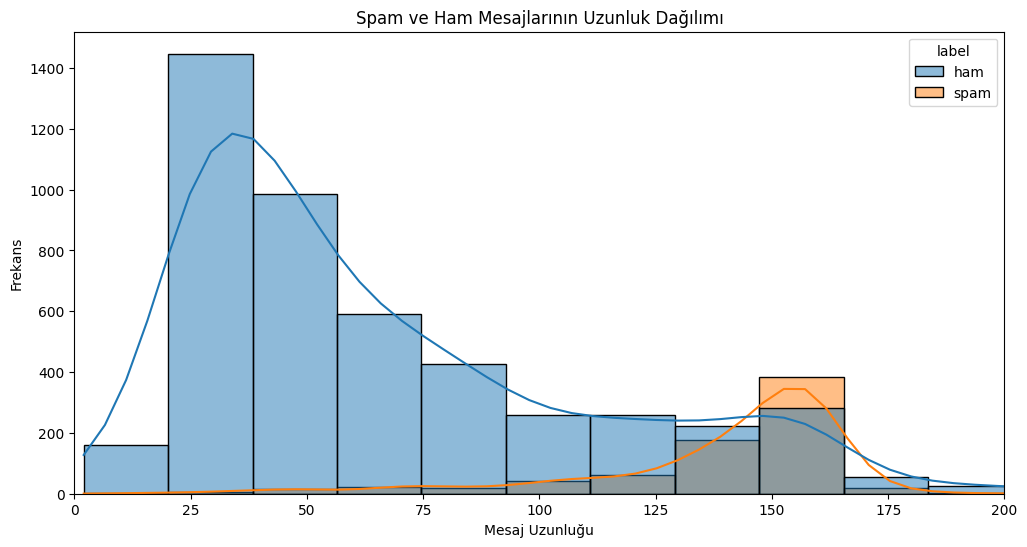

In [17]:

# Sınıf dağılımını görelim
print("\nSınıf dağılımı:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True)*100)

# Spam ve ham mesajlarının uzunluklarını inceleyelim
df['length'] = df['message'].apply(len)
print("\nMesaj uzunlukları istatistikleri:")
print(df.groupby('label')['length'].describe())

# Mesaj uzunluklarını görselleştirelim
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
plt.title('Spam ve Ham Mesajlarının Uzunluk Dağılımı')
plt.xlabel('Mesaj Uzunluğu')
plt.ylabel('Frekans')
plt.xlim(0, 200)  # Daha iyi görselleştirme için x eksenini sınırlayalım
plt.show()

In [18]:
## 3. Veri Ön İşleme (Preprocessing)

def preprocess_text(text):
    """
    Metin ön işleme fonksiyonu
    - Küçük harfe çevirme
    - Noktalama işaretlerini kaldırma
    - Sayıları kaldırma
    - Stopwords'leri kaldırma
    - Stemming ve Lemmatization uygulama
    """
    # Küçük harfe çevirme
    text = text.lower()

    # Noktalama işaretlerini kaldırma
    text = ''.join([char for char in text if char not in string.punctuation])

    # Sayıları kaldırma
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Stopwords'leri kaldırma
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Kelimeleri tekrar birleştirme
    return ' '.join(tokens)

# Ön işleme uygulama
df['processed_message'] = df['message'].apply(preprocess_text)

print("\nİşlenmiş ve ham mesaj örnekleri:")
for i in range(5):
    print(f"Orijinal: {df['message'][i]}")
    print(f"İşlenmiş: {df['processed_message'][i]}")
    print("-" * 80)


İşlenmiş ve ham mesaj örnekleri:
Orijinal: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
İşlenmiş: go jurong point crazi avail bugi n great world la e buffet cine got amor wat
--------------------------------------------------------------------------------
Orijinal: Ok lar... Joking wif u oni...
İşlenmiş: ok lar joke wif u oni
--------------------------------------------------------------------------------
Orijinal: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
İşlenmiş: free entri wkli comp win fa cup final tkt st may text fa receiv entri questionstd txt ratetc appli over
--------------------------------------------------------------------------------
Orijinal: U dun say so early hor... U c already then say...
İşlenmiş: u dun say earli hor u c alreadi say
--------------------------------------------------------

In [19]:
## 4. Öznitelik Çıkarımı (Feature Extraction)

# Label Encoding
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
print("\nLabel Encoding:")
print("Ham (0), Spam (1)")

# Veri setini eğitim ve test olarak bölelim
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_message'],
    df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

print("\nVeri seti bölünmesi:")
print(f"Eğitim seti boyutu: {X_train.shape[0]}")
print(f"Test seti boyutu: {X_test.shape[0]}")

# CountVectorizer (BoW) ve TF-IDF ile öznitelik çıkarımı
count_vectorizer = CountVectorizer(max_features=3000)
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

# Eğitim setini vektöre dönüştürme
X_train_counts = count_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Test setini vektöre dönüştürme
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nCountVectorizer ile öznitelik çıkarımı:")
print(f"Eğitim seti şekli: {X_train_counts.shape}")
print(f"Test seti şekli: {X_test_counts.shape}")

print("\nTF-IDF ile öznitelik çıkarımı:")
print(f"Eğitim seti şekli: {X_train_tfidf.shape}")
print(f"Test seti şekli: {X_test_tfidf.shape}")


Label Encoding:
Ham (0), Spam (1)

Veri seti bölünmesi:
Eğitim seti boyutu: 4457
Test seti boyutu: 1115

CountVectorizer ile öznitelik çıkarımı:
Eğitim seti şekli: (4457, 3000)
Test seti şekli: (1115, 3000)

TF-IDF ile öznitelik çıkarımı:
Eğitim seti şekli: (4457, 3000)
Test seti şekli: (1115, 3000)


In [20]:
## 5. Öznitelik Seçimi (Feature Selection)

# Chi-kare testi ile en iyi özellikleri seçme
selector = SelectKBest(chi2, k=1000)
X_train_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = selector.transform(X_test_tfidf)

print("\nÖznitelik seçimi sonrası:")
print(f"Eğitim seti şekli: {X_train_selected.shape}")
print(f"Test seti şekli: {X_test_selected.shape}")


Öznitelik seçimi sonrası:
Eğitim seti şekli: (4457, 1000)
Test seti şekli: (1115, 1000)


In [21]:
## 6. Model Eğitimi ve Değerlendirme

# Değerlendirme metrikleri için yardımcı fonksiyon
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Modeli eğiten ve değerlendiren fonksiyon
    """
    # Modeli eğitme
    model.fit(X_train, y_train)

    # Tahminler
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrikler
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Sonuçları yazdırma
    print(f"\n{'='*20} {model_name} {'='*20}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
     # Sınıflandırma raporu
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # ROC Eğrisi
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

    # Confusion Matrix görselleştirme
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, f1, auc_score, cm


==================== SVM ====================
Accuracy: 0.9794
F1-Score: 0.9181
AUC: 0.9729

Confusion Matrix:
[[963   3]
 [ 20 129]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



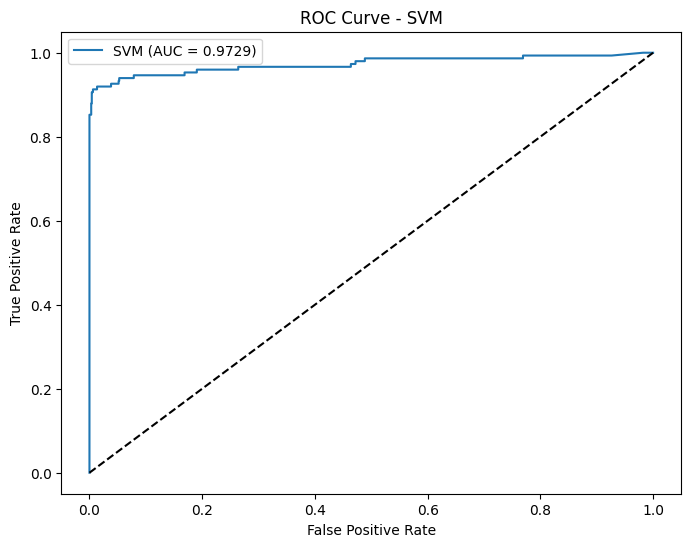

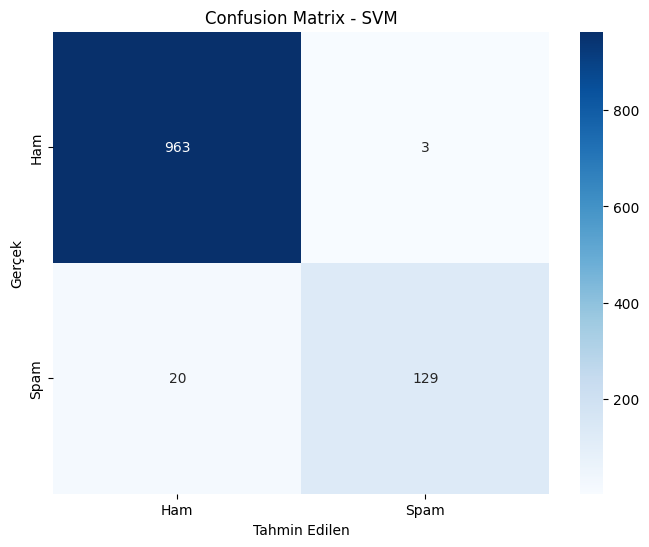


==================== Gradient Boosting ====================
Accuracy: 0.9632
F1-Score: 0.8453
AUC: 0.9665

Confusion Matrix:
[[962   4]
 [ 37 112]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.97      0.75      0.85       149

    accuracy                           0.96      1115
   macro avg       0.96      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



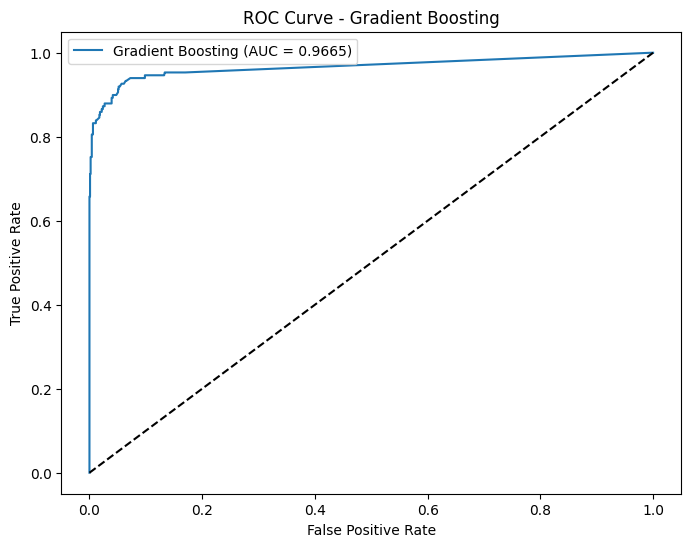

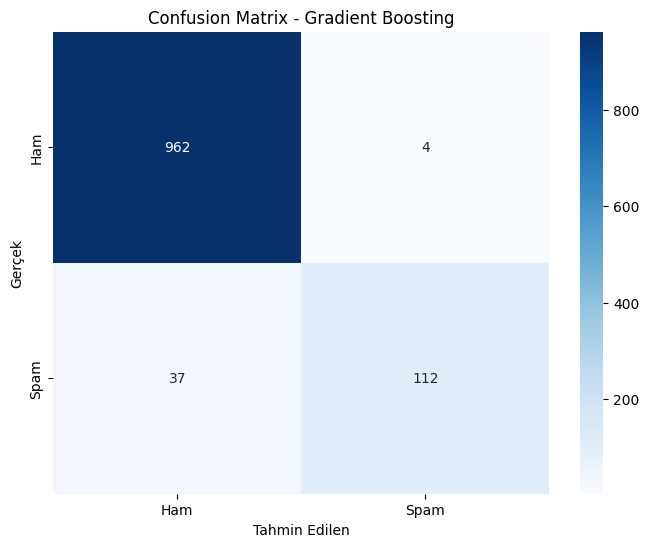


==================== Logistic Regression ====================
Accuracy: 0.9659
F1-Score: 0.8538
AUC: 0.9814

Confusion Matrix:
[[966   0]
 [ 38 111]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



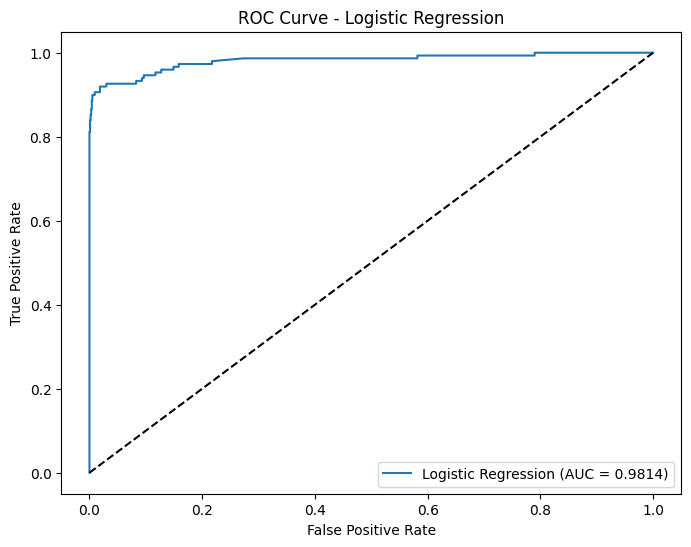

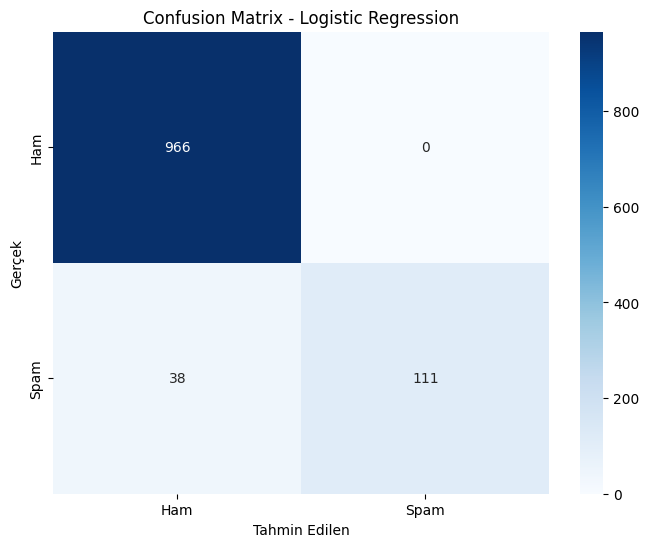


==================== Random Forest ====================
Accuracy: 0.9713
F1-Score: 0.8797
AUC: 0.9799

Confusion Matrix:
[[966   0]
 [ 32 117]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



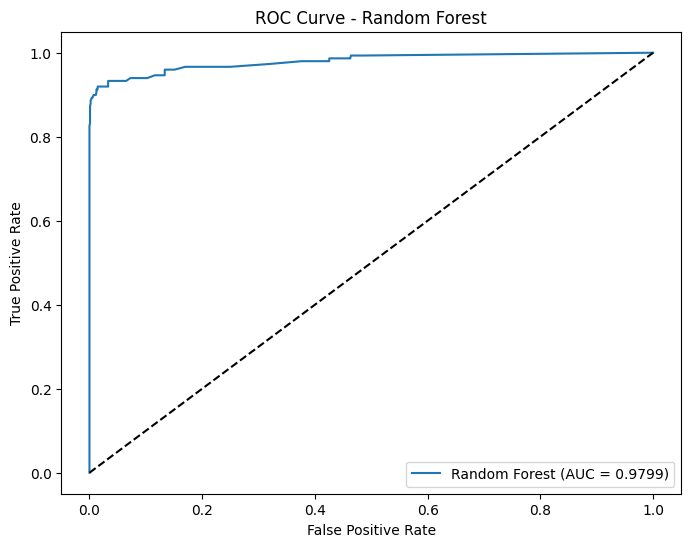

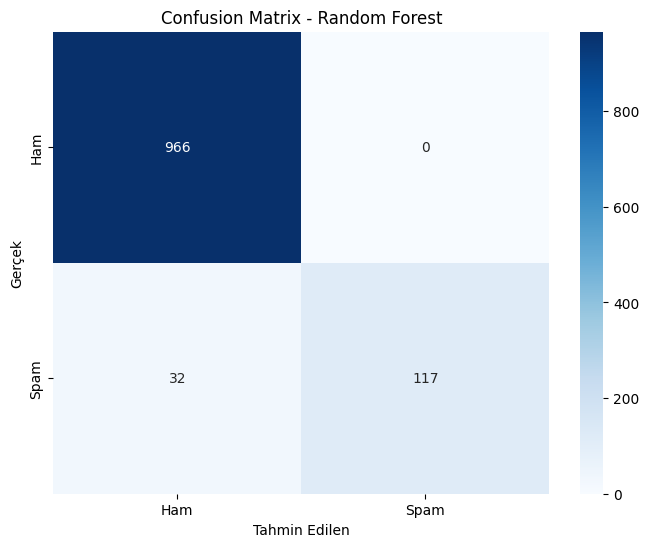

In [22]:

# Modelleri tanımlama
models = {
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
}

# Sonuçları saklamak için bir sözlük
results = {}

# Her modeli eğitme ve değerlendirme
for model_name, model in models.items():
    accuracy, f1, auc_score, cm = evaluate_model(
        model, X_train_selected, X_test_selected, y_train, y_test, model_name
    )
    results[model_name] = {
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm
    }


==================== Ensemble (Voting) ====================
Accuracy: 0.9794
F1-Score: 0.9164
AUC: 0.9849

Confusion Matrix:
[[966   0]
 [ 23 126]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



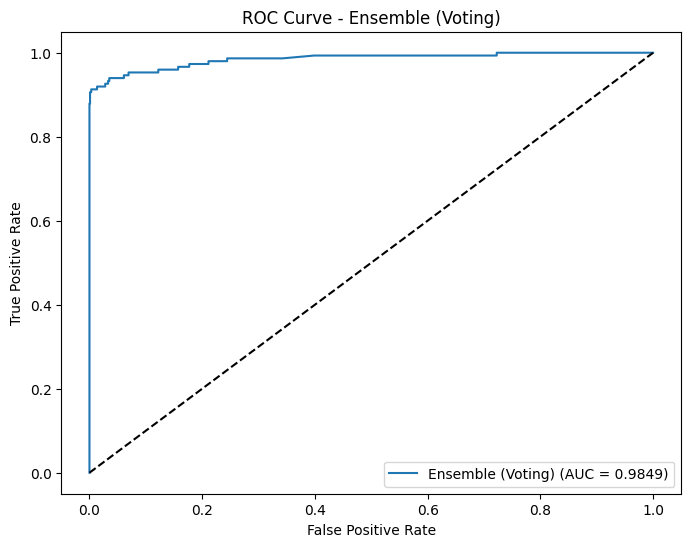

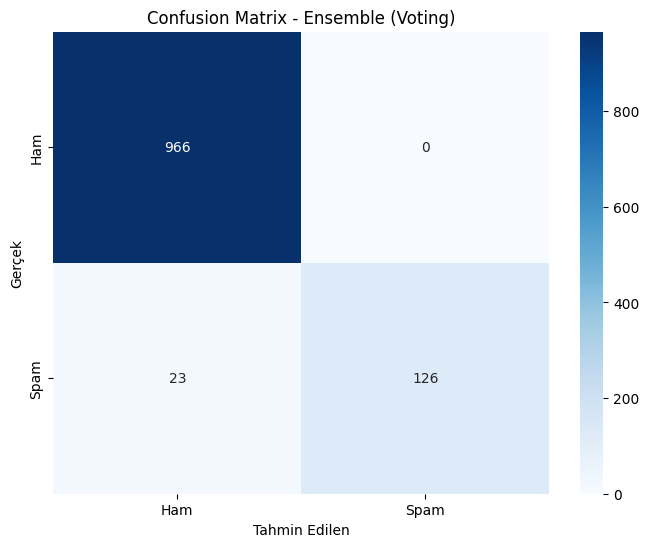

In [23]:
## 7. Ensemble Learning

# Voting Classifier oluşturma
voting_clf = VotingClassifier(estimators=[
    ('svm', SVC(probability=True, random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
], voting='soft')

# Ensemble modeli değerlendirme
accuracy, f1, auc_score, cm = evaluate_model(
    voting_clf, X_train_selected, X_test_selected, y_train, y_test, 'Ensemble (Voting)'
)
results['Ensemble (Voting)'] = {
    'accuracy': accuracy,
    'f1': f1,
    'auc': auc_score,
    'confusion_matrix': cm
}



Tüm Modellerin Karşılaştırması:
                 Model  Accuracy  F1-Score       AUC
0                  SVM  0.979372  0.918149  0.972876
1    Gradient Boosting  0.963229  0.845283  0.966505
2  Logistic Regression  0.965919  0.853846  0.981394
3        Random Forest  0.971300  0.879699  0.979918
4    Ensemble (Voting)  0.979372  0.916364  0.984882


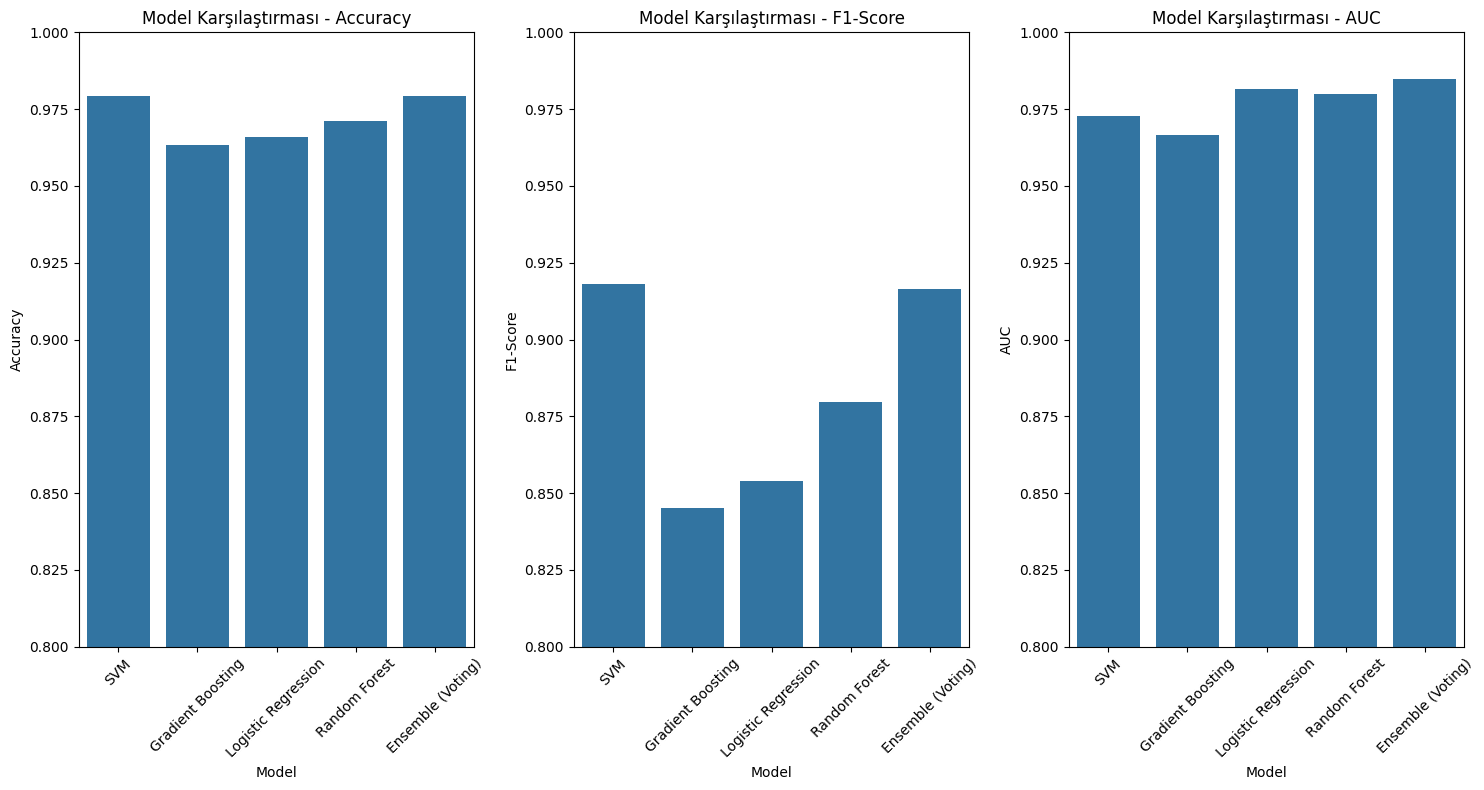

In [24]:
## 8. Sonuçların Karşılaştırılması

# Sonuçları DataFrame'e dönüştürme
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'F1-Score': [results[model]['f1'] for model in results],
    'AUC': [results[model]['auc'] for model in results]
})

print("\n\nTüm Modellerin Karşılaştırması:")
print(results_df)

# Metrikleri görselleştirme
metrics = ['Accuracy', 'F1-Score', 'AUC']
plt.figure(figsize=(15, 8))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model Karşılaştırması - {metric}')
    plt.xticks(rotation=45)
    plt.ylim(0.8, 1.0)  # Daha iyi karşılaştırma için y-eksenini ayarlayalım

plt.tight_layout()
plt.show()

In [25]:
## 9. En İyi Modelin Seçilmesi ve Kaydedilmesi

# En yüksek F1 skoruna sahip modeli bulma
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"\nEn iyi model (F1-Score'a göre): {best_model_name}")

# Tüm veri üzerinde en iyi modeli tekrar eğitme
if best_model_name == 'Ensemble (Voting)':
    best_model = voting_clf
else:
    best_model = models[best_model_name]

# Tüm veri üzerinde öznitelik çıkarımı ve seçimi
full_tfidf = tfidf_vectorizer.transform(df['processed_message'])
full_selected = selector.transform(full_tfidf)

# En iyi modeli tüm veri üzerinde eğitme
best_model.fit(full_selected, df['label_encoded'])

# Pipeline oluşturma (Preprocessing + Feature Extraction + Feature Selection + Model)
spam_classifier_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('selector', selector),
    ('classifier', best_model)
])

# Test için örnek mesajlar
test_messages = [
    "Congratulations! You've won a $1000 gift card. Call now to claim your prize!",
    "Hi, can we meet at 5pm tomorrow for the project discussion?",
    "URGENT: Your bank account has been suspended. Call this number immediately.",
    "I'll be late for dinner, please start without me."
]

# İşlenmemiş mesajları doğrudan test etme (preprocessing pipeline içinde)
for message in test_messages:
    processed = preprocess_text(message)
    # Pipeline kullanarak tahmin yapma
    proba = best_model.predict_proba(selector.transform(tfidf_vectorizer.transform([processed])))[0, 1]
    prediction = "Spam" if proba > 0.5 else "Ham"
    print(f"Mesaj: {message}")
    print(f"Tahmin: {prediction} (Spam olasılığı: {proba:.4f})")
    print("-" * 80)



En iyi model (F1-Score'a göre): SVM
Mesaj: Congratulations! You've won a $1000 gift card. Call now to claim your prize!
Tahmin: Spam (Spam olasılığı: 1.0000)
--------------------------------------------------------------------------------
Mesaj: Hi, can we meet at 5pm tomorrow for the project discussion?
Tahmin: Ham (Spam olasılığı: 0.0115)
--------------------------------------------------------------------------------
Mesaj: URGENT: Your bank account has been suspended. Call this number immediately.
Tahmin: Spam (Spam olasılığı: 0.7314)
--------------------------------------------------------------------------------
Mesaj: I'll be late for dinner, please start without me.
Tahmin: Ham (Spam olasılığı: 0.0138)
--------------------------------------------------------------------------------


In [26]:
## 10. Sonuç ve Değerlendirme

print("\n\nSonuç ve Değerlendirme:")
print(f"En iyi model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"AUC: {results[best_model_name]['auc']:.4f}")




Sonuç ve Değerlendirme:
En iyi model: SVM
Accuracy: 0.9794
F1-Score: 0.9181
AUC: 0.9729
